# Training Data Visualization
This notebook helps visualize the generated training data as grid images.


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# ARC color scheme (10 colors: 0-9)
ARC_COLORS = [
    '#000000',  # 0: black
    '#0074D9',  # 1: blue
    '#FF4136',  # 2: red
    '#2ECC40',  # 3: green
    '#FFDC00',  # 4: yellow
    '#AAAAAA',  # 5: gray
    '#F012BE',  # 6: magenta
    '#FF851B',  # 7: orange
    '#7FDBFF',  # 8: sky blue
    '#870C25'   # 9: maroon
]

arc_cmap = ListedColormap(ARC_COLORS)


Visualizing training examples with predicted outputs:


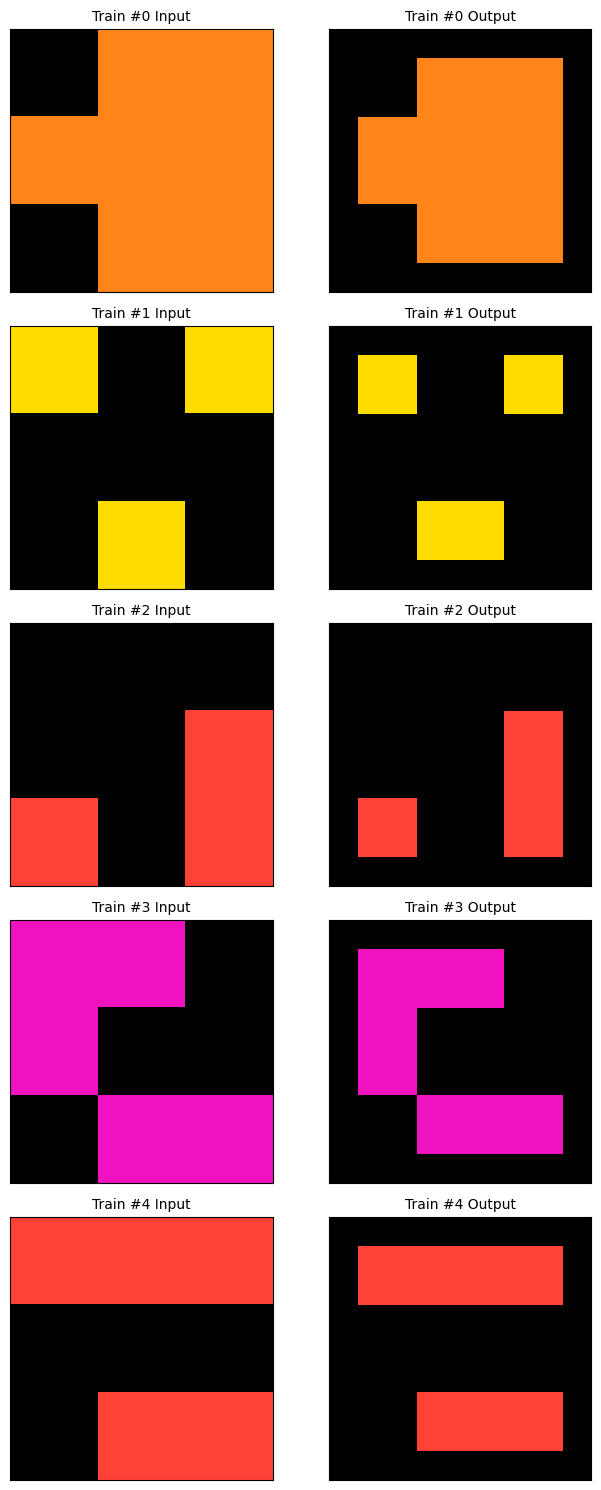

Visualizing test examples with predicted outputs:


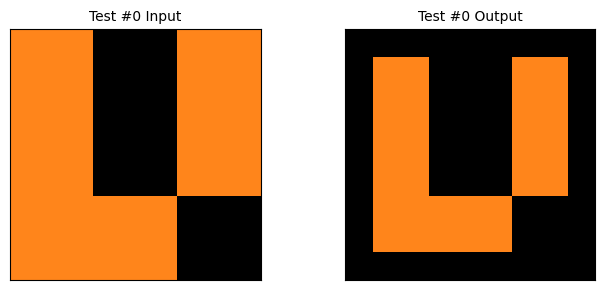

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the predicted task file
with open("soar_training_data/007bbfb7_pred_6.json") as f:
    pred_task = json.load(f)

def plot_arc_grids(data_pair_list, set_name="train"):
    """Plot predicted and target grids for ARC data."""
    num = len(data_pair_list)
    fig, axs = plt.subplots(num, 2, figsize=(7, num*3))
    if num == 1:
        axs = np.expand_dims(axs, 0)
    for i, eg in enumerate(data_pair_list):
        grid_in = np.array(eg['input'])
        grid_out = np.array(eg['output'])
        axs[i, 0].imshow(grid_in, cmap=arc_cmap, vmin=0, vmax=9)
        axs[i, 0].set_title(f"{set_name.capitalize()} #{i} Input", fontsize=10)
        axs[i, 0].set_xticks([]), axs[i, 0].set_yticks([])
        axs[i, 1].imshow(grid_out, cmap=arc_cmap, vmin=0, vmax=9)
        axs[i, 1].set_title(f"{set_name.capitalize()} #{i} Output", fontsize=10)
        axs[i, 1].set_xticks([]), axs[i, 1].set_yticks([])
    plt.tight_layout()
    plt.show()

print("Visualizing training examples with predicted outputs:")
plot_arc_grids(pred_task['train'], set_name="train")

print("Visualizing test examples with predicted outputs:")
plot_arc_grids(pred_task['test'], set_name="test")


In [ ]:
def text_to_grid(text):
    """Convert text representation of grid to numpy array."""
    lines = text.strip().split('\n')
    grid = []
    for line in lines:
        row = [int(x) for x in line.split()]
        grid.append(row)
    return np.array(grid)

def plot_grid(grid, title="", ax=None):
    """Plot a single grid."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.imshow(grid, cmap=arc_cmap, vmin=0, vmax=9)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, which='both', color='white', linewidth=0.5)
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    
    return ax


## Load and Visualize Training Data


In [ ]:
# Load training data from JSON file
json_file = "test_output_eval.json"  # Change to your file

with open(json_file, 'r', encoding='utf-8') as f:
    training_data = json.load(f)

print(f"Loaded {len(training_data)} training examples")
print(f"\nFirst example metadata:")
for key, value in training_data[0]['metadata'].items():
    print(f"  {key}: {value}")


## Visualize Test Input, Placeholder, and Ground Truth


In [ ]:
# Select an example to visualize
example_idx = 0
example = training_data[example_idx]

# Extract the last input (test input) and answer (ground truth)
problem_lines = example['problem'].split('\n')
answer_lines = example['answer'].split('\n')

# Find test case input
test_input_start = None
for i, line in enumerate(problem_lines):
    if line.strip() == "Test Case:":
        # Find "Input:" after "Test Case:"
        for j in range(i+1, len(problem_lines)):
            if problem_lines[j].strip() == "Input:":
                test_input_start = j + 1
                break
        break

# Find test case output (placeholder)
test_output_start = None
for i, line in enumerate(problem_lines):
    if line.strip() == "Output:" and test_input_start and i > test_input_start:
        test_output_start = i + 1
        break

# Extract grids
test_input_lines = []
test_output_lines = []

if test_input_start:
    for i in range(test_input_start, len(problem_lines)):
        line = problem_lines[i].strip()
        if line == "" or line == "Output:":
            break
        if line and not line.startswith("Example") and not line.startswith("Training"):
            test_input_lines.append(line)

if test_output_start:
    for i in range(test_output_start, len(problem_lines)):
        line = problem_lines[i].strip()
        if line == "":
            break
        if line and not line.startswith("Example"):
            test_output_lines.append(line)

# Convert to grids
test_input = text_to_grid('\n'.join(test_input_lines))
test_placeholder = text_to_grid('\n'.join(test_output_lines)) if test_output_lines else None
ground_truth = text_to_grid(example['answer'])

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_grid(test_input, "Test Input", axes[0])
if test_placeholder is not None:
    plot_grid(test_placeholder, f"Placeholder (Level {example['metadata']['level']})", axes[1])
plot_grid(ground_truth, "Ground Truth", axes[2])

metadata = example['metadata']
title = f"{metadata['concept']} - {metadata['problem_name']} | "
title += f"Method: {metadata['method']} | Level: {metadata['level']} | Aug: {metadata['augmentation_idx']}"
fig.suptitle(title, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Show same problem across different levels
# Filter examples with same augmentation but different levels
aug_idx_filter = 0
placeholder_idx_filter = 0

examples_by_level = {}
for ex in training_data:
    meta = ex['metadata']
    if meta.get('augmentation_idx') == aug_idx_filter and meta.get('placeholder_idx') == placeholder_idx_filter:
        examples_by_level[meta['level']] = ex

print(f"Found examples for {len(examples_by_level)} levels")

# Plot all levels
num_levels = len(examples_by_level)
if num_levels > 0:
    fig, axes = plt.subplots(num_levels, 3, figsize=(18, 6 * num_levels))
    if num_levels == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (level, ex) in enumerate(sorted(examples_by_level.items())):
        # Extract grids (same parsing logic)
        problem_lines = ex['problem'].split('\n')
        
        test_input_start = None
        for i, line in enumerate(problem_lines):
            if line.strip() == "Test Case:":
                for j in range(i+1, len(problem_lines)):
                    if problem_lines[j].strip() == "Input:":
                        test_input_start = j + 1
                        break
                break
        
        test_output_start = None
        for i, line in enumerate(problem_lines):
            if line.strip() == "Output:" and test_input_start and i > test_input_start:
                test_output_start = i + 1
                break
        
        test_input_lines = []
        test_output_lines = []
        
        if test_input_start:
            for i in range(test_input_start, len(problem_lines)):
                line = problem_lines[i].strip()
                if line == "" or line == "Output:":
                    break
                if line and not line.startswith("Example"):
                    test_input_lines.append(line)
        
        if test_output_start:
            for i in range(test_output_start, len(problem_lines)):
                line = problem_lines[i].strip()
                if line == "":
                    break
                if line:
                    test_output_lines.append(line)
        
        test_input = text_to_grid('\n'.join(test_input_lines))
        test_placeholder = text_to_grid('\n'.join(test_output_lines)) if test_output_lines else None
        ground_truth = text_to_grid(ex['answer'])
        
        # Plot
        plot_grid(test_input, f"Level {level} - Input", axes[idx, 0])
        if test_placeholder is not None:
            plot_grid(test_placeholder, f"Level {level} - Placeholder", axes[idx, 1])
        plot_grid(ground_truth, f"Level {level} - Ground Truth", axes[idx, 2])
    
    plt.tight_layout()
    plt.show()
